<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/NAT_AOCC_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install colab-env --upgrade -q
import colab_env

In [4]:
!pip install uv -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 46.8 MB/s eta 0:00:00


In [ ]:
!uv pip install "nvidia-nat[all]"

Function registry cleared
════════════════════════════════════════════════════════════
   NVIDIA NAT • HYBRID SIMULATION (FUEL & RECOVERY)
════════════════════════════════════════════════════════════
[OBSERVABILITY] NV-2030 → Latency: 373.21ms
[OBSERVABILITY] NV-2027 → Latency: 399.90ms
[OBSERVABILITY] NV-2026 → Latency: 408.97ms
[OBSERVABILITY] NV-2029 → Latency: 442.50ms
[OBSERVABILITY] NV-2028 → Latency: 505.73ms
[NV-2026] Flight NV-2026 was cancelled due to crew fatigue, resulting in a $25,350 financial loss.
[NV-2027] Flight NV-2027 has been cancelled due to crew fatigue, resulting in a $37,950 financial loss.
[NV-2028] Flight NV-2028 swapped aircraft due to a tail minor equipment list (MEL) issue, replacing the original aircraft with N559NV at a cost of $23344.
[NV-2029] Flight NV-2029 has been cancelled due to a Minimum Equipment List (MEL) maintenance issue, resulting in a $25,000 cost.
[NV-2030] Flight NV-2030 has been cancelled due to crew fatigue, resulting in a $41,800 fina

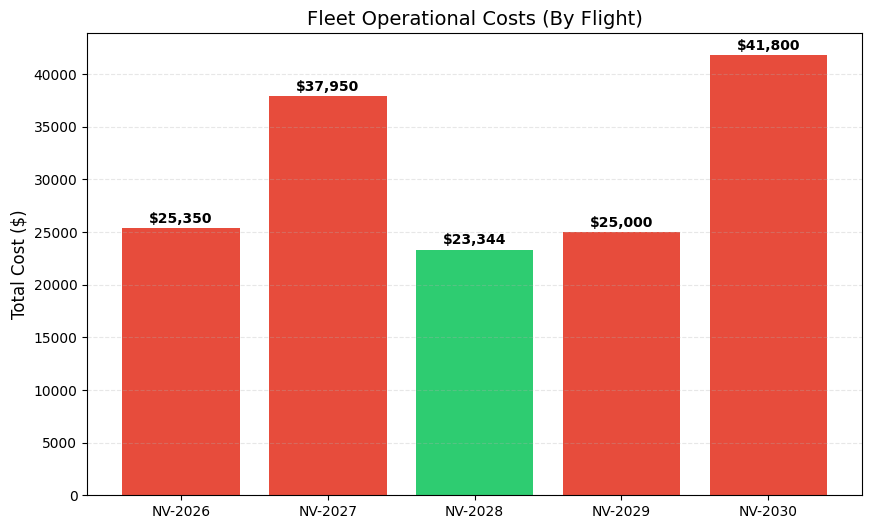

In [13]:
import asyncio
import random
import os
import getpass
import time
from typing import Dict, Any
from openai import AsyncOpenAI
import nest_asyncio
import matplotlib.pyplot as plt

# Apply nest_asyncio to allow nested loops in Colab
nest_asyncio.apply()

from nat.cli.register_workflow import register_function
from nat.data_models.function import FunctionBaseConfig
from nat.cli.type_registry import GlobalTypeRegistry
from pydantic import Field

# 1. Setup Environment
try:
    GlobalTypeRegistry.get()._registered_functions.clear()
    print("Function registry cleared")
except Exception:
    pass

if "NVIDIA_API_KEY" not in os.environ:
    os.environ["NVIDIA_API_KEY"] = getpass.getpass("Enter your NVIDIA API key: ")

client = AsyncOpenAI(
    base_url="https://integrate.api.nvidia.com/v1",
    api_key=os.environ["NVIDIA_API_KEY"]
)

# 2. Input Models
class WeatherInput(FunctionBaseConfig, name="weather_input"):
    flight_id: str = Field(..., description="Flight number")

class CrewInput(FunctionBaseConfig, name="crew_input"):
    flight_id: str = Field(..., description="Flight number")

class MaintenanceInput(FunctionBaseConfig, name="maintenance_input"):
    flight_id: str = Field(..., description="Flight number")

class PaxInput(FunctionBaseConfig, name="pax_input"):
    flight_id: str = Field(..., description="Flight number")

class FleetInput(FunctionBaseConfig, name="fleet_input"):
    flight_id: str = Field(..., description="Flight number")

class ATCInput(FunctionBaseConfig, name="atc_input"):
    flight_id: str = Field(..., description="Flight number")

class FuelInput(FunctionBaseConfig, name="fuel_input"):
    flight_id: str = Field(..., description="Flight number")
    destination: str = Field(..., description="Destination airport code")

class RecoveryInput(FunctionBaseConfig, name="recovery_input"):
    flight_id: str = Field(..., description="Flight number")
    requirement: str = Field(..., description="Resource to recover")

class CostInput(FunctionBaseConfig, name="cost_input"):
    flight_id: str = Field(..., description="Flight number")
    decision: str = Field(..., description="Final decision")
    delay_minutes: int = Field(default=0)
    pax_count: int = Field(default=0)
    fuel_cost: float = Field(default=0.0)

class ObservabilityInput(FunctionBaseConfig, name="observability_input"):
    flight_id: str = Field(..., description="Flight number")
    trace: Dict[str, Any] = Field(..., description="Execution data")
    latency_ms: float = Field(..., description="Total processing time")

class RefinerInput(FunctionBaseConfig, name="refiner_input"):
    decision: str = Field(..., description="Final decision")
    reason: str = Field(..., description="Reasoning")
    flight_id: str = Field(..., description="Flight number")
    cost: int = Field(default=0)

# 3. Logic Agents
@register_function(config_type=WeatherInput)
async def register_weather(config, builder):
    async def logic(input_data):
        status = random.choice(["CLEAR", "THUNDERSTORMS", "FOG", "STRONG_WINDS"])
        return {"status": status, "severity": "HIGH" if status != "CLEAR" else "LOW"}
    yield logic

@register_function(config_type=FuelInput)
async def register_fuel(config, builder):
    async def logic(input_data):
        prices = {"JFK": 5.10, "LAX": 5.85, "ORD": 4.95, "DFW": 4.50}
        price = prices.get(input_data.destination, 5.25)
        gallons = random.randint(2500, 4500)
        return {"fuel_cost": price * gallons}
    yield logic

@register_function(config_type=CrewInput)
async def register_crew(config, builder):
    async def logic(input_data):
        hours = random.randint(1, 14)
        return {"ready": hours >= 5, "hours_left": hours}
    yield logic

@register_function(config_type=MaintenanceInput)
async def register_maintenance(config, builder):
    async def logic(input_data):
        return {"status": random.choice(["GO", "AOG", "DEFERRED", "MEL"])}
    yield logic

@register_function(config_type=PaxInput)
async def register_pax(config, builder):
    async def logic(input_data):
        return {"count": random.randint(0, 50)}
    yield logic

@register_function(config_type=FleetInput)
async def register_fleet(config, builder):
    async def logic(input_data):
        return {"spare_ready": random.choice([True, False]), "sub_tail": f"N{random.randint(100, 999)}NV"}
    yield logic

@register_function(config_type=ATCInput)
async def register_atc(config, builder):
    async def logic(input_data):
        return {"delay": random.choice([0, 15, 45, 90])}
    yield logic

@register_function(config_type=RecoveryInput)
async def register_recovery(config, builder):
    async def logic(input_data):
        return {"success": random.random() < 0.4}
    yield logic

@register_function(config_type=CostInput)
async def register_cost(config, builder):
    async def logic(input_data):
        base_costs = {
            "PROCEED": 0,
            "DELAY": input_data.delay_minutes * 101,
            "SWAP AIRCRAFT": 5000,
            "CANCEL": 25000 + (input_data.pax_count * 350)
        }
        total = base_costs.get(input_data.decision, 0)
        # Fuel only counts if the flight actually moves
        if input_data.decision != "CANCEL":
            total += input_data.fuel_cost
        return {"total_cost": int(total)}
    yield logic

@register_function(config_type=ObservabilityInput)
async def register_observability(config, builder):
    async def logic(input_data):
        print(f"[OBSERVABILITY] {input_data.flight_id} → Latency: {input_data.latency_ms:.2f}ms")
    yield logic

@register_function(config_type=RefinerInput)
async def register_refiner(config, builder):
    async def logic(input_data):
        response = await client.chat.completions.create(
            model="meta/llama-3.1-8b-instruct",
            messages=[
                {"role": "system", "content": "You are a concise Airline Ops bot. Provide a 1-sentence summary."},
                {"role": "user", "content": f"Flight {input_data.flight_id}: {input_data.decision} due to {input_data.reason}. Cost ${input_data.cost}."}
            ],
            temperature=0.1
        )
        return {"notification": response.choices[0].message.content}
    yield logic

# 4. Orchestrator
async def run_full_aocc(flight_id: str, dest: str):
    start_time = time.perf_counter()
    async with register_weather(None, None) as weather_logic, \
               register_crew(None, None) as crew_logic, \
               register_maintenance(None, None) as mx_logic, \
               register_pax(None, None) as pax_logic, \
               register_fleet(None, None) as fleet_logic, \
               register_atc(None, None) as atc_logic, \
               register_fuel(None, None) as fuel_logic, \
               register_recovery(None, None) as recovery_logic, \
               register_cost(None, None) as cost_logic, \
               register_observability(None, None) as obs_logic, \
               register_refiner(None, None) as refiner_logic:

        w, p, a, c, m, f, fuel = await asyncio.gather(
            weather_logic(WeatherInput(flight_id=flight_id)),
            pax_logic(PaxInput(flight_id=flight_id)),
            atc_logic(ATCInput(flight_id=flight_id)),
            crew_logic(CrewInput(flight_id=flight_id)),
            mx_logic(MaintenanceInput(flight_id=flight_id)),
            fleet_logic(FleetInput(flight_id=flight_id)),
            fuel_logic(FuelInput(flight_id=flight_id, destination=dest))
        )

        if not c["ready"]:
            rec = await recovery_logic(RecoveryInput(flight_id=flight_id, requirement="CREW"))
            decision, reason = ("DELAY", "Crew standby activated") if rec["success"] else ("CANCEL", f"Crew fatigued ({c['hours_left']}h)")
        elif m["status"] != "GO":
            decision, reason = ("SWAP AIRCRAFT", f"Tail {m['status']} -> {f['sub_tail']}") if f["spare_ready"] else ("CANCEL", f"Maintenance issue ({m['status']})")
        elif w["severity"] == "HIGH" or a["delay"] >= 60:
            decision, reason = "DELAY", f"Weather ({w['status']}) / ATC Delay"
        else:
            decision, reason = "PROCEED", "Nominal conditions"

        cost_rep = await cost_logic(CostInput(
            flight_id=flight_id, decision=decision, delay_minutes=a["delay"], pax_count=p["count"], fuel_cost=fuel["fuel_cost"]
        ))

        final = await refiner_logic(RefinerInput(decision=decision, reason=reason, flight_id=flight_id, cost=cost_rep["total_cost"]))
        latency = (time.perf_counter() - start_time) * 1000
        await obs_logic(ObservabilityInput(flight_id=flight_id, trace={}, latency_ms=latency))

        return {"id": flight_id, "cost": cost_rep["total_cost"], "summary": final["notification"]}

# 5. Visualization Function
def plot_fleet_costs(results_data):
    ids = [r['id'] for r in results_data]
    costs = [r['cost'] for r in results_data]

    plt.figure(figsize=(10, 6))
    colors = ['#e74c3c' if 'cancelled' in r['summary'].lower() else '#2ecc71' for r in results_data]
    bars = plt.bar(ids, costs, color=colors)

    plt.title('Fleet Operational Costs (By Flight)', fontsize=14)
    plt.ylabel('Total Cost ($)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, f'${bar.get_height():,}', ha='center', fontweight='bold')
    plt.show()

# 6. Execution
async def run_simulation_cycle(count=5):
    random.seed(42)
    dests = ["JFK", "LAX", "ORD", "DFW", "ATL"]
    print("═"*60 + "\n   NVIDIA NAT • HYBRID SIMULATION (FUEL & RECOVERY)\n" + "═"*60)

    tasks = [run_full_aocc(f"NV-{2026+i}", dests[i % 5]) for i in range(count)]
    results_list = await asyncio.gather(*tasks)

    for r in results_list:
        print(f"[{r['id']}] {r['summary']}")
    print("─"*60 + f"\nTotal Fleet Cost: ${sum(r['cost'] for r in results_list):,}\n" + "─"*60)

    return results_list

# Run it
results = await run_simulation_cycle(5)
plot_fleet_costs(results)